# Multiscale non-Gaussian segmentation

This tutorial is using most of the functions provided in the PYWAVAN library.

If you do not have the PYWAVAN library, you must clone and install it first:

(you must uncomment the lines while keeping the "!")

In [4]:
#!cd /path_where_you_want_to_clone

#!git clone https://github.com/jfrob27/pywavan.git
#!cd pywavan
#!pip install .

Let's first create a fractional Brownian motion (fBm) map as a simple representation of the interstellar medium.

In [5]:
%pylab inline
from pywavan import fbm2d
plt.style.use(['dark_background'])

Populating the interactive namespace from numpy and matplotlib


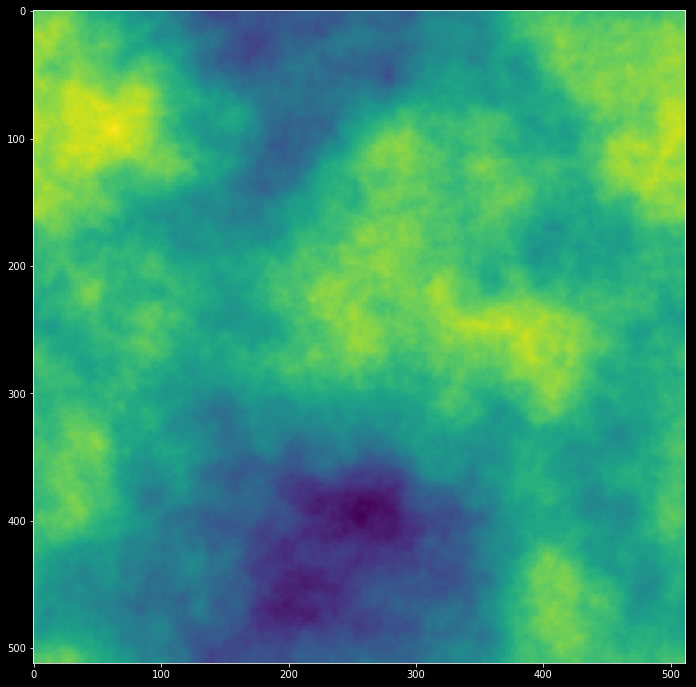

In [24]:
#Create a nx X ny pixels map with a power law gamma
nx = 512
ny = 512
gamma = -3.6
fbm = fbm2d(gamma, ny,nx)

#Display the map
figure(figsize=(12,12))
imshow(fbm)

To this monofractal structure we add artificial filaments.

In [33]:
from scipy.ndimage import rotate
from pywavan import imsmooth

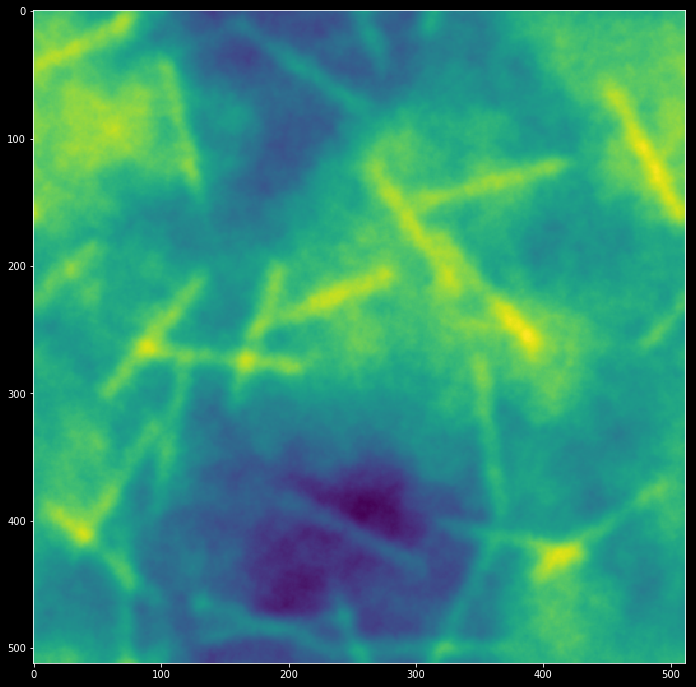

In [46]:
#Filament size and initial position
fsz = 128
pos = np.array([ny/2-1,nx/2-1])

#Number of orientations and filaments
N=25
delt=180/N

#Random shift for the different filaments
shx = np.random.randn(N)*250.
shy = np.random.randn(N)*250.

#Filaments layer
imfiltot = np.zeros((ny,nx))

#Loop to create all filaments
for i in range(N):
    imfil = imfiltot * 0.
    imfil[(pos[0]-fsz/2):(pos[0]+fsz/2)-1,pos[1]] = 1.
    angl = delt*i
    imfil = rotate(imfil,angl,reshape=False)
    imfil = np.roll(imfil,np.int(shx[i]),axis=1)
    imfil = np.roll(imfil,np.int(shy[i]),axis=0)
    imfiltot += imfil
    
#Impose filaments width
FWHM = 15
imfiltot = imsmooth(imfiltot,FWHM)
    
#Create image total
imtot = fbm + imfiltot * 10.
    
#Display the filament layer
figure(figsize=(12,12))
imshow(imtot)

Now that we have a mock-ISM, we can analyse its power spectrum.

In [47]:
from pywavan import powspec

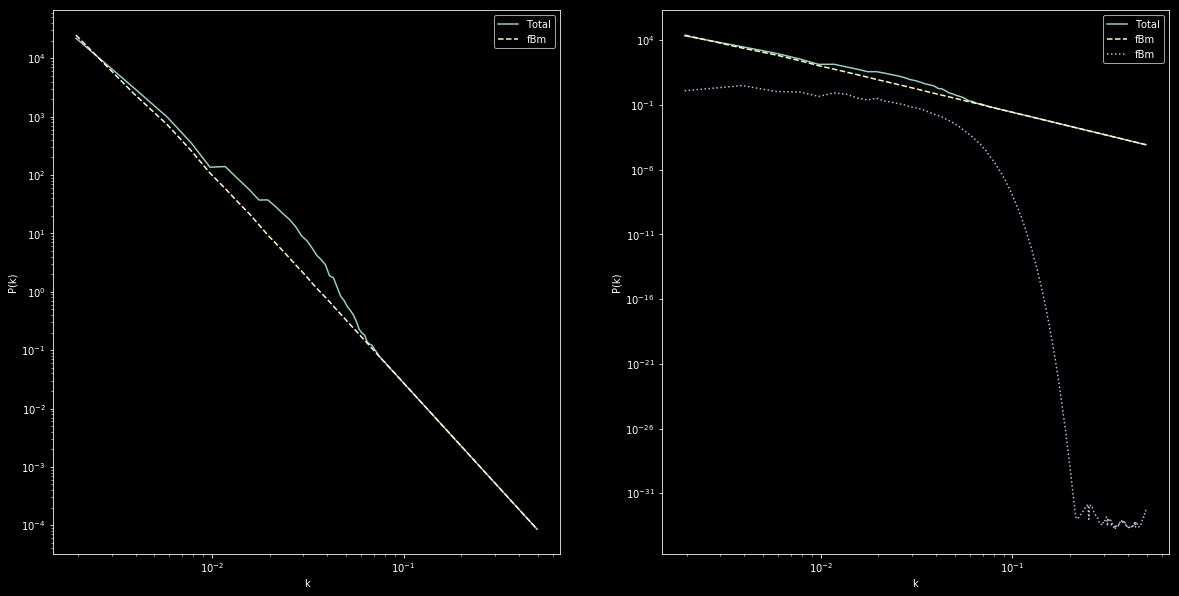

In [56]:
#Calculate the total image Fourier power spectrum
tab_k, spec_ktot = powspec(imtot, reso=1.)

#Calculate the fBm power spectrum only
tab_k, spec_kfbm = powspec(fbm, reso=1.)

#Calculate the filaments power spectrum only
tab_k, spec_kfil = powspec(imfiltot, reso=1.)

#Plot the power spectra in log-log
figure(figsize=(20,10))
plt.subplot(1,2,1)
plot(tab_k, spec_ktot, label='Total')
plot(tab_k, spec_kfbm, linestyle='--', label='fBm')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()

plt.subplot(1,2,2)
plot(tab_k, spec_ktot, label='Total')
plot(tab_k, spec_kfbm, linestyle='--', label='fBm')
plot(tab_k, spec_kfil, linestyle=':', label='fBm')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()

As we can, the fBm as a unique power law, whereas the random filments have essentially the power spectrum of the Gaussian smoothing kernel. The random mock-filaments create a bump around $2 \times 10^{-2}$ pixel$^{-1}$ in the total power spectrum. In reality, the integration of interstellar filaments to the background is much more complicated. The purpose of this example, is only to introduce the different PYWAVAN functions and to demonstrate the capabilities the Multiscale non-Gaussian Segmentation (MnGSeg) method.

Now we can apply the segmentation methode in order to separate the two component, i.e. the fBm and the filaments.